<a href="https://colab.research.google.com/github/AhmadiJahid/CS512_HW3/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
f_path = "/content/Sensorless_drive_diagnosis.txt"
data = pd.read_csv(f_path, delimiter=" ", header=None)

# Separate features and labels
X = data.iloc[:, :-1]
y = data.iloc[:, -1]-1

# Split the dataset into train, validation, and test sets (60%, 20%, 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [3]:
X_train.shape

(35105, 48)


Number of Trees: 10
Label range: 0 - 10
Prediction shape: (11702, 11)
Prediction sample: [0.04398996 0.04397086 0.5574167  0.04403863 0.04676948 0.0439702
 0.04395762 0.04398841 0.04397946 0.04396112 0.04395758]
Sum of probabilities (should be ~1): 1.0
Validation AUC: 0.9995091962274802

Number of Trees: 50
Label range: 0 - 10
Prediction shape: (11702, 11)
Prediction sample: [0.00112016 0.00111213 0.9870329  0.00117658 0.00282984 0.00111938
 0.00111092 0.0011564  0.00111919 0.00111166 0.00111091]
Sum of probabilities (should be ~1): 1.0000001
Validation AUC: 0.9999449680452598

Number of Trees: 100
Label range: 0 - 10
Prediction shape: (11702, 11)
Prediction sample: [2.7615833e-05 2.0803183e-05 9.9950087e-01 2.4513402e-05 2.0515251e-04
 3.5163186e-05 2.0289752e-05 4.9760627e-05 7.4774456e-05 2.0731608e-05
 2.0346390e-05]
Sum of probabilities (should be ~1): 1.0
Validation AUC: 0.9999923139728017

Number of Trees: 500
Label range: 0 - 10
Prediction shape: (11702, 11)
Prediction sample:

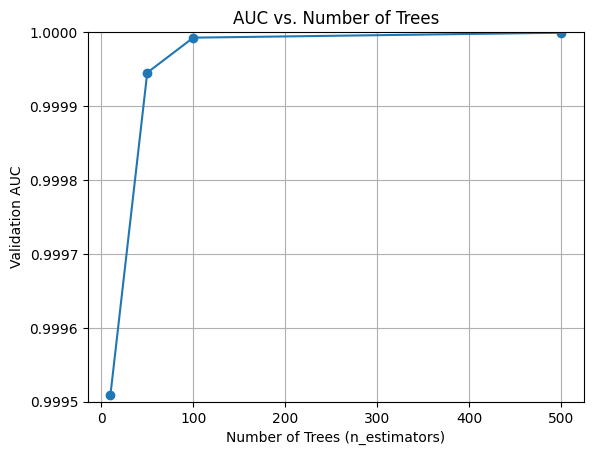

In [6]:
# Hyperparameter tuning: n_estimators
n_estimators_list = [10, 50, 100, 500]
auc_scores = []

for n_estimators in n_estimators_list:
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=0.1,
        random_state=42,
        eval_metric="mlogloss"  # Avoid deprecated parameters
    )
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)

    # Debugging checks
    print(f"\nNumber of Trees: {n_estimators}")
    print("Label range:", y_val.min(), "-", y_val.max())
    print("Prediction shape:", y_val_pred.shape)
    print("Prediction sample:", y_val_pred[0])
    print("Sum of probabilities (should be ~1):", y_val_pred[0].sum())

    # Compute AUC
    auc = roc_auc_score(y_val, y_val_pred, multi_class='ovr', average='micro')
    auc_scores.append(auc)
    print("Validation AUC:", auc)

plt.ylim(0.9995, 1.0)  # Focus on the narrow range
plt.plot(n_estimators_list, auc_scores, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Validation AUC")
plt.title("AUC vs. Number of Trees")
plt.grid()
plt.show()

Even though *n_estimators_list[np.argmax(auc_scores)]* shows that the maximum score is got when the number of trees are 500, after printing out the values we can observe that the difference between 100 and 500 trees is negligible and in order to avoid **overfitting**, I will use **100** **as the best n_estimator**.

In [8]:
print("n_estimators:", n_estimators_list)
print("AUC scores:", auc_scores)

n_estimators: [10, 50, 100, 500]
AUC scores: [0.9995091962274802, 0.9999449680452598, 0.9999923139728017, 0.9999990009990302]


In [16]:
# Use a threshold to prioritize simplicity
threshold = 1e-5  # Allow small differences in AUC
max_auc = max(auc_scores)
valid_indices = [i for i, auc in enumerate(auc_scores) if max_auc - auc <= threshold]

# Select the smallest n_estimators within the threshold
best_n_estimators = min([n_estimators_list[i] for i in valid_indices])
print("Best n_estimators:", best_n_estimators)


Best n_estimators: 100


In [14]:
max_depth_list = [4, 6, 8]
auc_scores_depth = []

for max_depth in max_depth_list:
    model = XGBClassifier(n_estimators=best_n_estimators, learning_rate=0.1, max_depth=max_depth, random_state=42, eval_metric="mlogloss")
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_val_pred, multi_class='ovr', average='micro')
    auc_scores_depth.append(auc)



Best max_depth: 8


In [15]:
print("max_depth:", max_depth_list)
print("AUC scores:", auc_scores_depth)

max_depth: [4, 6, 8]
AUC scores: [0.9999766432404834, 0.9999923139728017, 0.999997044622131]


In [17]:
# Use a threshold to prioritize simplicity
threshold = 1e-5  # Allow small differences in AUC
max_auc_depth = max(auc_scores_depth)
valid_depth_indices = [i for i, auc in enumerate(auc_scores_depth) if max_auc_depth - auc <= threshold]

# Select the smallest max_depth within the threshold
best_max_depth = min([max_depth_list[i] for i in valid_depth_indices])
print("Best max_depth:", best_max_depth)


Best max_depth: 6


Learning rate: 0.001
Validation AUC: 0.9983270275535275
Learning rate: 0.01
Validation AUC: 0.9994906453344712
Learning rate: 0.1
Validation AUC: 0.9999923139728017


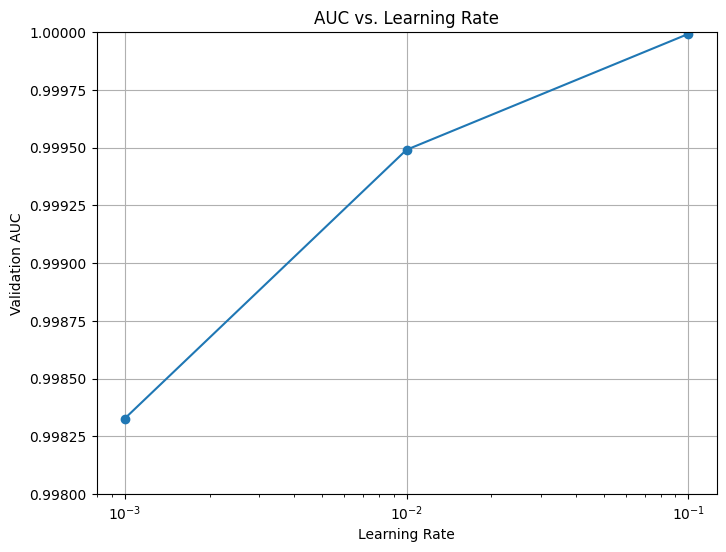

Best learning_rate: 0.1


In [20]:
# Define the list of learning rates to tune
learning_rate_list = [0.001, 0.01, 0.1]
auc_scores_lr = []

for learning_rate in learning_rate_list:
    model = XGBClassifier(
        n_estimators=best_n_estimators,  # Use the best n_estimators from previous step
        learning_rate=learning_rate,
        max_depth=best_max_depth,  # Use the best max_depth from previous step
        random_state=42,
        eval_metric="mlogloss"
    )
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)

    # Compute AUC for validation set
    auc = roc_auc_score(y_val, y_val_pred, multi_class='ovr', average='micro')
    auc_scores_lr.append(auc)

    # Debugging output
    print(f"Learning rate: {learning_rate}")
    print("Validation AUC:", auc)

# Plot AUC vs. Learning Rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rate_list, auc_scores_lr, marker='o')
plt.xscale('log')  # Log scale for learning rate
plt.ylim(0.998, 1.0)  # Adjust y-axis range if needed
plt.xlabel("Learning Rate")
plt.ylabel("Validation AUC")
plt.title("AUC vs. Learning Rate")
plt.grid()
plt.show()

# Use a threshold to select the best learning rate
threshold = 1e-5  # Allow small differences in AUC
max_auc_lr = max(auc_scores_lr)
valid_lr_indices = [i for i, auc in enumerate(auc_scores_lr) if max_auc_lr - auc <= threshold]

# Select the smallest learning rate within the threshold
best_learning_rate = min([learning_rate_list[i] for i in valid_lr_indices])
print("Best learning_rate:", best_learning_rate)


Test AUC: 0.999988720344313


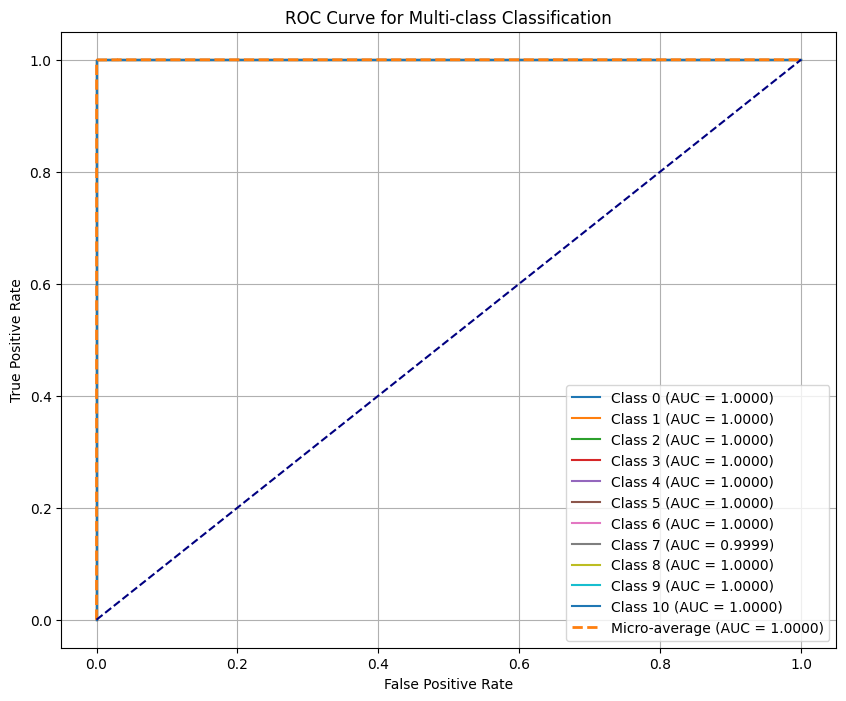

In [22]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Combine training and validation sets
X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

# Best hyperparameters (replace these with the tuned values from your experiments)
best_n_estimators = 100
best_max_depth = 6
best_learning_rate = 0.1  #Retrain the model with the best hyperparameters on combined training + validation data
final_model = XGBClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    random_state=42,
    eval_metric="mlogloss"
)
final_model.fit(X_train_final, y_train_final)

# Predict probabilities on the test set
y_test_pred = final_model.predict_proba(X_test)

# Calculate the test AUC
test_auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr', average='micro')
print("Test AUC:", test_auc)

# Plot the ROC Curve
plt.figure(figsize=(10, 8))
fpr = {}
tpr = {}
roc_auc = {}

# Convert y_test to a one-hot encoded matrix
y_test_onehot = pd.get_dummies(y_test).to_numpy()

# Compute ROC curve and ROC area for each class
for i in range(11):  # Adjust range for the number of classes (0 to 10)
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.4f})")

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_onehot.ravel(), y_test_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average (AUC = {roc_auc_micro:.4f})", linestyle='--', linewidth=2)

# Add plot details
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-class Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()